# Value Investor

- Author: Yumo Bai
- Email: baiym104@gmail.com
- Date: May 10, 2023

## Import libraries & Data

In [3]:
import zipfile

local_zip = './data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.')
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import os

filenames = os.listdir('data')

# We will store the stock data for all companies by their company code
stock_dfs = {}

In [6]:
def get_company_code(name):
  return name[name.find("(")+1:name.find(")")]

get_company_code('2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv')

'PAMP'

In [7]:
for fname in filenames:
  stock_dfs[get_company_code(fname)] = pd.read_csv(os.path.join('./data', fname))

In [8]:
stock_dfs['PAMP'].head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",85.15,86.5,88.1,85.15,564.30K,-1.10%
1,"Mar 30, 2021",86.1,85.15,86.75,84.6,141.40K,1.29%
2,"Mar 29, 2021",85,80,86,79,371.22K,3.85%
3,"Mar 26, 2021",81.85,84,84.6,80.7,462.55K,-2.09%
4,"Mar 25, 2021",83.6,85.2,87.3,82.1,389.78K,-3.13%


In [9]:
stock_dfs['PAMP'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      301 non-null    object
 1   Price     301 non-null    object
 2   Open      301 non-null    object
 3   High      301 non-null    object
 4   Low       301 non-null    object
 5   Vol.      300 non-null    object
 6   Change %  300 non-null    object
dtypes: object(7)
memory usage: 16.6+ KB


## Data Preprocessing

We notice that the last row of the datasets stores a summary of the stock price change which should be discarded for modelling in the future.

In [10]:
stock_dfs['PAMP'].tail()

,Date,Price,Open,High,Low,Vol.,Change %
296,"Jan 07, 2020",47.6,48.35,49,46.9,901.95K,-1.86%
297,"Jan 06, 2020",48.5,48.4,48.7,47,719.24K,-0.61%
298,"Jan 03, 2020",48.8,48.25,49.45,46.5,595.36K,1.14%
299,"Jan 02, 2020",48.25,49.35,50.2,47.55,878.50K,-2.92%
300,Highest: 90.000,Lowest: 32.000,Difference: 58.000,Average: 61.244,Change %: 71.328,NaN,NaN


In [11]:
for code in stock_dfs:
  df = stock_dfs[code]
  df.drop(df.tail(1).index,inplace=True)

In [12]:
# The last row is successfully removed
stock_dfs['PAMP'].tail()

,Date,Price,Open,High,Low,Vol.,Change %
295,"Jan 08, 2020",46.5,47.5,47.5,46,1.18M,-2.31%
296,"Jan 07, 2020",47.6,48.35,49,46.9,901.95K,-1.86%
297,"Jan 06, 2020",48.5,48.4,48.7,47,719.24K,-0.61%
298,"Jan 03, 2020",48.8,48.25,49.45,46.5,595.36K,1.14%
299,"Jan 02, 2020",48.25,49.35,50.2,47.55,878.50K,-2.92%


Now we need to convert the `Price` to numerical representation.

In [13]:
for code in stock_dfs:
  df = stock_dfs[code]
  df['Price'] = df['Price'].apply(lambda x: float(''.join(x.split(','))))

We notice that the `Date` is currently stored as string. It might be helpful to convert them into datetime for further uses.

In [14]:
from datetime import datetime

for code in stock_dfs:
  df = stock_dfs[code]
  df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%b %d, %Y'))

In [15]:
# the Date column has successfully been transformed
stock_dfs['PAMP'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      300 non-null    datetime64[ns]
 1   Price     300 non-null    float64       
 2   Open      300 non-null    object        
 3   High      300 non-null    object        
 4   Low       300 non-null    object        
 5   Vol.      300 non-null    object        
 6   Change %  300 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 16.5+ KB


To represent the dates numerically, we can calculate how many days after was a data point recorded from the baseline date, for which we will choose Jan 1, 2020.

In [16]:
for code in stock_dfs:
  df = stock_dfs[code]
  df['date_diff'] = df['Date'].apply(lambda x: (x - datetime.strptime('Jan 01, 2020', '%b %d, %Y')).days)
  df.sort_values(by='date_diff', ascending=True, inplace=True)

In [17]:
stock_dfs['PAMP'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 299 to 0
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       300 non-null    datetime64[ns]
 1   Price      300 non-null    float64       
 2   Open       300 non-null    object        
 3   High       300 non-null    object        
 4   Low        300 non-null    object        
 5   Vol.       300 non-null    object        
 6   Change %   300 non-null    object        
 7   date_diff  300 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 21.1+ KB


Now we can visualize how the price changed for each company.

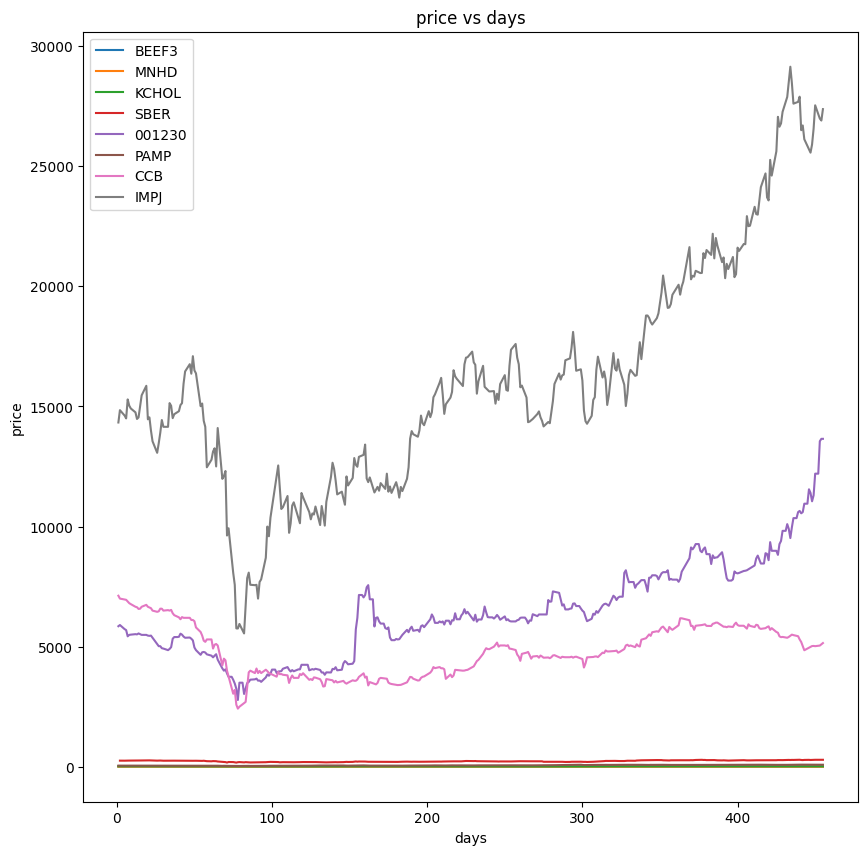

In [18]:
plt.figure(figsize=(10,10))

for code in stock_dfs:
  df = stock_dfs[code]
  plt.plot(df['date_diff'], df['Price'], label = code)

plt.xlabel('days')
plt.ylabel('price')
plt.title('price vs days')
plt.legend()
plt.show()

Out of the 8 stocks that we have, IMPJ, 001230 and CCB are significantly more expensive comparing to the others. We can exclude these 3 and see how the others perform.

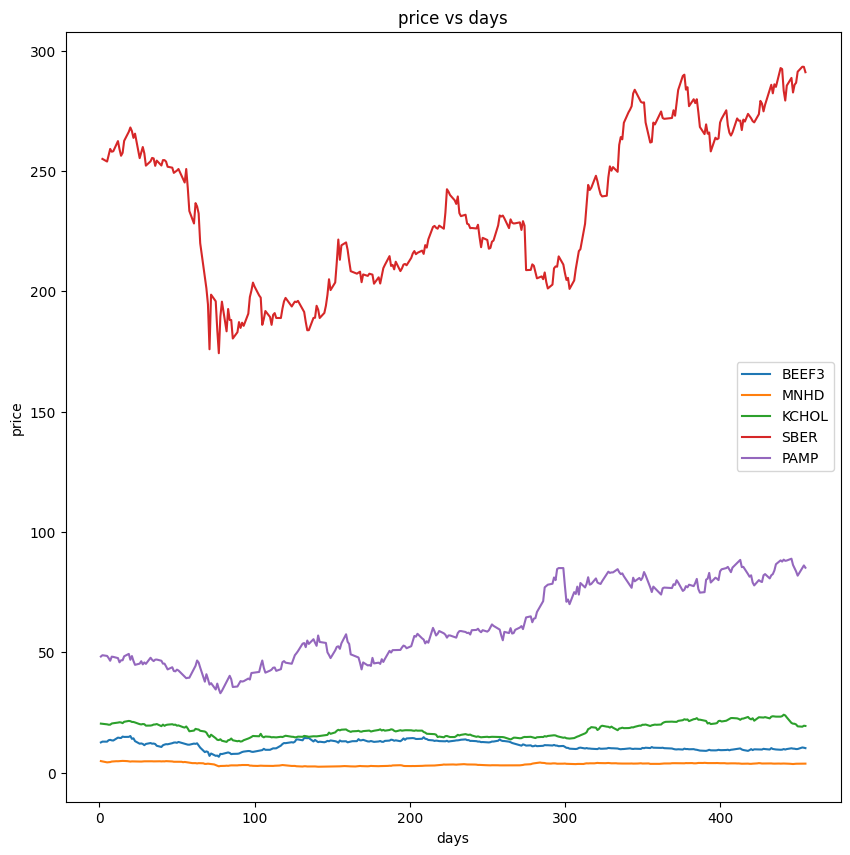

In [19]:
plt.figure(figsize=(10,10))

for code in stock_dfs:
  if code in ['IMPJ', '001230', 'CCB']:
    continue
  df = stock_dfs[code]
  plt.plot(df['date_diff'], df['Price'], label = code)

plt.xlabel('days')
plt.ylabel('price')
plt.title('price vs days')
plt.legend()
plt.show()

It seems that MNHD is performing stably at the low price range that is below 5 whereas the other stocks flunctuates a bit more.

We will pick 'PAMP' for our initial attempt of modelling.

## Preparing the datasets

In [20]:
# We will define a helper function to transform our data into batches padded to the same length
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

def windowed_dataset(input, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(input)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [21]:
# Training set: price from 2020, Testing set: price from 2021
def train_test_split(df):
  series = df['Price']

  # Get the index of the first data point in 2021
  idx_2021 = df['Date'].apply(lambda x: x.year == 2021).argmax()

  time_train = df['Date'].values[:idx_2021]
  time_test = df['Date'].values[idx_2021:]
  
  train_set = series[:idx_2021].values
  test_set = series[idx_2021-WINDOW_SIZE:].values

  return idx_2021, time_train, train_set, time_test, test_set

In [22]:
df = stock_dfs['PAMP']
idx_2021, time_train, train_set, time_test, test_set = train_test_split(df)

In [23]:
import tensorflow as tf

# Convert training dataset to tf dataset
train = tf.convert_to_tensor(train_set)
test = tf.convert_to_tensor(test_set)

In [24]:
train = windowed_dataset(train)
test = windowed_dataset(test)

## Modelling by Moving Average

In [25]:
def pred_MA(series, window_size=WINDOW_SIZE, output_length=60):
  y_pred = list(series[-window_size:])
  for i in range(output_length):
    y_pred.append(sum(y_pred[-window_size:])/window_size)

  return y_pred[-output_length:]

y_pred = pred_MA(train_set, output_length=len(time_test))
y_true = df.Price[idx_2021:].values.reshape(-1, 1)

In [26]:
# We will evaluate the predictions by MAE
def MAE(y_true, y_pred):
  return np.sum(np.abs(y_pred - y_true))/len(y_true)

In [27]:
print(f'MAE: {MAE(y_true, y_pred)}')

MAE: 238.6509150556856


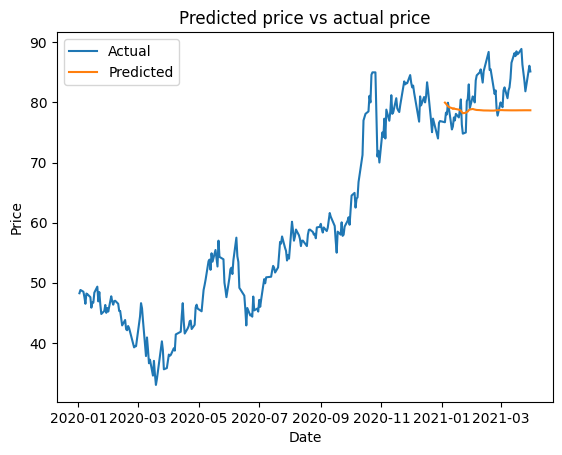

In [28]:
plt.figure()
plt.plot(df['Date'], df['Price'], label='Actual')
plt.plot(time_test, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted price vs actual price')
plt.legend()
plt.show()

## Modelling with RNN

To construct a model for the dataset, we firstly need to build a data pipe that could feed the input data to the model.

In [29]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[WINDOW_SIZE, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 68,575
Trainable params: 68,575
Non-traina

In [30]:
history = model.fit(train, epochs=100)

Epoch 1/100
7/7 [==============================] - 5s 72ms/step - loss: 55.2658
Epoch 2/100
7/7 [==============================] - 0s 30ms/step - loss: 52.3513
Epoch 3/100
7/7 [==============================] - 0s 29ms/step - loss: 49.2527
Epoch 4/100
7/7 [==============================] - 0s 31ms/step - loss: 45.4982
Epoch 5/100
7/7 [==============================] - 0s 29ms/step - loss: 41.3212
Epoch 6/100
7/7 [==============================] - 0s 30ms/step - loss: 36.6580
Epoch 7/100
7/7 [==============================] - 0s 29ms/step - loss: 31.4445
Epoch 8/100
7/7 [==============================] - 0s 32ms/step - loss: 25.6538
Epoch 9/100
7/7 [==============================] - 0s 29ms/step - loss: 19.4685
Epoch 10/100
7/7 [==============================] - 0s 30ms/step - loss: 14.0066
Epoch 11/100
7/7 [==============================] - 0s 31ms/step - loss: 11.5784
Epoch 12/100
7/7 [==============================] - 0s 46ms/step - loss: 10.9881
Epoch 13/100
7/7 [===================

In [31]:
model.predict(train_set[-WINDOW_SIZE:].reshape(-1,1))

1/1 [==============================] - 1s 1s/step


array([[19.863157],
       [19.873304],
       [19.863945],
       [19.85744 ],
       [19.859928],
       [19.849604],
       [19.797516],
       [19.844069],
       [19.829067],
       [19.843119],
       [19.834255],
       [19.844069],
       [19.864344],
       [19.853157],
       [19.80007 ],
       [19.7736  ],
       [19.80383 ],
       [19.7578  ],
       [19.79493 ],
       [19.798798]], dtype=float32)

In [32]:
def pred_RNN(series, window_size=WINDOW_SIZE, output_length=60):
  input = list(series[-window_size:])
  for i in range(output_length):
    y_pred.append(sum(y_pred[-window_size:])/window_size)

  return y_pred[-output_length:]

In [33]:
windows = []

for batch in list(test.as_numpy_iterator()):
  windows.append(batch[0])

test_inputs = np.vstack(windows)

In [34]:
y_pred = model.predict(test_inputs)

y_true = df.Price[idx_2021:].values.reshape(-1, 1)

print(f'MAE: {MAE(y_true, y_pred)}')

2/2 [==============================] - 1s 13ms/step
MAE: 3.498535690307618


Now let's compare our prediction to the actual data.

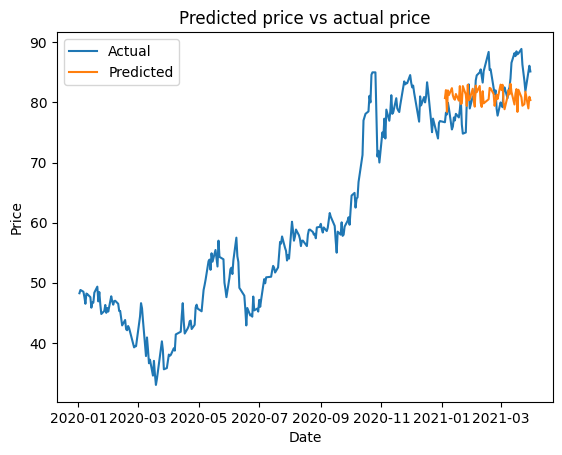

In [35]:
plt.figure()
plt.plot(df['Date'], df['Price'], label='Actual')
plt.plot(time_test, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted price vs actual price')
plt.legend()
plt.show()

## Modelling with Prophet

In [ ]:
!pip install prophet

In [52]:
from prophet import Prophet
m = Prophet(daily_seasonality=True)

temp_df = df[df['Date'].apply(lambda x: x.year < 2021)][['Date', 'Price']]
temp_df.rename({'Date': 'ds', 'Price': 'y'}, axis='columns', inplace=True)

m.fit(temp_df)
future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)
pd.options.display.max_columns = None
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj8_t7swa/07tadmfy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj8_t7swa/hsf0x32i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45458', 'data', 'file=/tmp/tmpj8_t7swa/07tadmfy.json', 'init=/tmp/tmpj8_t7swa/hsf0x32i.json', 'output', 'file=/tmp/tmpj8_t7swa/prophet_modela9sln4bd/prophet_model-20230601154647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds       yhat  yhat_lower  yhat_upper
295 2021-02-24  96.907434   91.199907  102.570698
296 2021-02-25  97.247680   91.359189  102.725632
297 2021-02-26  97.619165   91.805614  103.218846
298 2021-02-27  97.883537   92.282743  103.682660
299 2021-02-28  98.093486   92.204753  104.023126


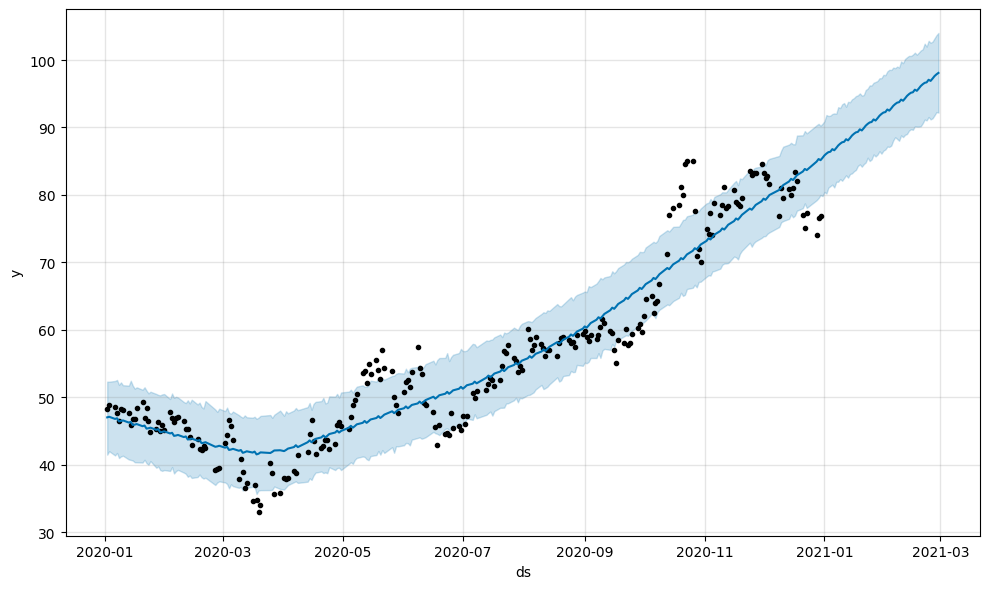

In [53]:
figure1 = m.plot(forecast)